# Assignment 1
Tiny Imagenet

In [ ]:
# %load_ext autoreload
# %autoreload 2
# import some necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms

from datasets import load_dataset
from myDataset import MyDataset

from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# some experimental setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 128
batch_size = 256
num_workers = 8
# print_every = 200

optim_name = "AdamW"
optim_kwargs = dict(
    lr=3e-4,
)

# preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "valid"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) +
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
print(f"device: {device}")


device: cuda:0


In [ ]:
# prepare datasets
dataset, loader = {}, {}

# cifar10
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )

# tiny-imagenet
def to_tensor(example):
	return {
        "image" : torch.tensor(example["image"].clone().detach().expand(3, -1, -1), dtype=torch.float32),
        "label" : torch.tensor(example["label"].clone().detach(), dtype=torch.long)
        }

# def train_trans(examples):
#     examples["image"] = transformation['train'](examples["image"])
#     return examples

# def valid_trans(examples):
#     examples["image"] = transformation['valid'](examples["image"])
#     return examples

for data_type in ("train", "valid"):
    is_train = data_type=="train"
    dataset[data_type] = load_dataset("zh-plus/tiny-imagenet", split=data_type, cache_dir="./data")
    dataset[data_type] = dataset[data_type].with_format("torch")
    dataset[data_type] = dataset[data_type].map(to_tensor)
    my_dataset = MyDataset(dataset[data_type], data_type)
    loader[data_type] = torch.utils.data.DataLoader(
        my_dataset, batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )

print(f"train sample: {len(dataset['train'])}, valid samples: {len(dataset['valid'])}")
print(f"train batches: {len(loader['train'])}, valid batches: {len(loader['valid'])}")

Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data\zh-plus___tiny-imagenet\default\0.0.0\5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Wed Oct 29 12:19:24 2025).
Using the latest cached version of the dataset since zh-plus/tiny-imagenet couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at data\zh-plus___tiny-imagenet\default\0.0.0\5a77092c28e51558c5586e9c5eb71a7e17a5e43f (last modified on Wed Oct 29 12:19:24 2025).


train sample: 100000, valid samples: 10000
train batches: 391, valid batches: 40


In [ ]:
# dataset1 = MyDataset(dataset['train'], 'train')
# print(dataset1)
# loader1 = torch.utils.data.DataLoader(
#         dataset1, batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )
# for batch in loader1:
#     print(batch['image'].shape, batch['label'].shape)
#     break

torch.Size([256, 3, 64, 64]) torch.Size([256])


### Baseline

In [4]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.model(x)


### Residual Mechanism

In [5]:
class MyResBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(MyResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, padding=1)
        if in_c != out_c:
            self.conv3 = nn.Conv2d(in_c, out_c, 1, stride=stride)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_c)
        self.bn2 = nn.BatchNorm2d(out_c)

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = F.relu(self.bn2(self.conv2(y)))
        if self.conv3 is not None:
            x = self.conv3(x)
        return F.relu(x + y)

class MyResnet(nn.Module):
    def __init__(self, num_block=1):
        super(MyResnet, self).__init__()
        self.before_res = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
        )
        self.res = nn.Sequential(
            *[MyResBlock(32, 32) for _ in range((num_block - 1) * 1)],
            MyResBlock(32, 64, 2), *[MyResBlock(64, 64) for _ in range((num_block - 1) * 2)], nn.Dropout(0.05),
            MyResBlock(64, 128, 2), *[MyResBlock(128, 128) for _ in range((num_block - 1) * 4)], nn.Dropout(0.05),
            MyResBlock(128, 256, 2), *[MyResBlock(256, 256) for _ in range((num_block - 1) * 2)], nn.Dropout(0.05),
            MyResBlock(256, 512, 2), *[MyResBlock(512, 512) for _ in range((num_block - 1) * 1)], nn.Dropout(0.05),
        )
        self.after_res = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 200)
        )

    def forward(self, x):
        return self.after_res(self.res(self.before_res(x)))


### Attention

In [6]:
# our network architecture
class MyAttentionBlock(nn.Module):
    def __init__(self, d_attn, num_heads=4):
        super(MyAttentionBlock, self).__init__()
        self.num_heads = num_heads
        self.mha = nn.MultiheadAttention(embed_dim=d_attn, num_heads=num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Conv2d(d_attn, d_attn*4, 1), nn.ReLU(inplace=True),
            nn.Conv2d(d_attn*4, d_attn, 1),
        )
        self.bn1 = nn.BatchNorm2d(d_attn)
        self.bn2 = nn.BatchNorm2d(d_attn)

    def forward(self, x):
        B, C, W, H = x.shape
        x_flat = x.flatten(2).permute(0, 2, 1)  # B, L, C
        attn_out, _ = self.mha(x_flat, x_flat, x_flat)
        attn_out = attn_out.permute(0, 2, 1).reshape(B, C, W, H)
        attn_out = F.relu(attn_out + x)
        attn_out = self.bn1(attn_out)
        out = self.ffn(attn_out) + attn_out
        out = self.bn2(out)
        return out

class MyAttention(nn.Module):
    def __init__(self, num_block=1):
        super(MyAttention, self).__init__()
        self.before_attn = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
        )
        self.attn = nn.Sequential(
            MyResBlock(64, 128, 2), *[MyAttentionBlock(128) for _ in range(num_block)],
            MyResBlock(128, 256, 2), *[MyAttentionBlock(256) for _ in range(num_block)],
            MyResBlock(256, 512, 2), *[MyAttentionBlock(512) for _ in range(num_block)],
        )
        self.after_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), nn.Linear(512, 200)
        )

    def forward(self, x):
        return self.after_attn(self.attn(self.before_attn(x)))


In [7]:
# move to device
model = MyResnet(num_block=2)
model.to(device)

# print the number of parameters
print(f"number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad) / 1_000_000:.2f}M")

number of parameters: 13.42M


## Start Training

  0%|          | 0/128 [00:48<?, ?it/s]

Finished Training


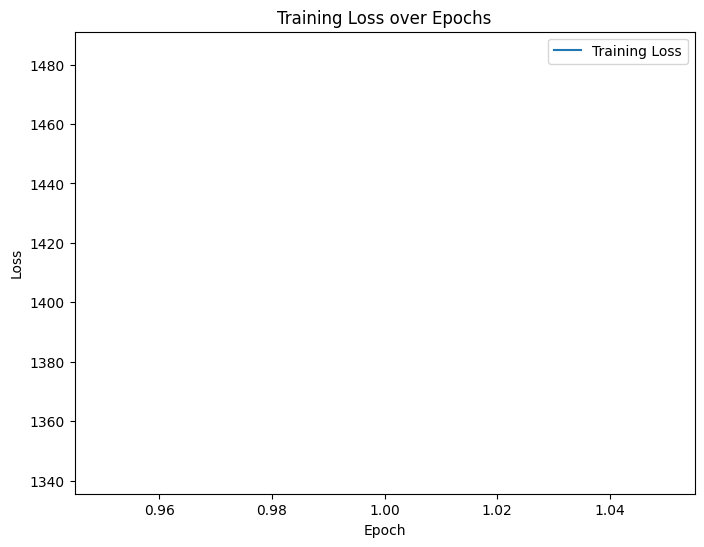

In [ ]:
# the network optimizer
optimizer = getattr(optim, optim_name)(model.parameters(), **optim_kwargs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# loss function
criterion = nn.CrossEntropyLoss()

# training loop
model.train()
loss_record = []
for epoch in range(num_epochs):

    running_loss = 0.0
    for i, batch in tqdm(enumerate(loader["train"]), total=len(loader["train"])):
        img, target = batch['image'].to(device), batch['label'].to(device)

        pred = model(img)
        loss = criterion(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % print_every == print_every - 1:
        #     print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
        #     running_loss = 0.0
    print(f"[epoch={epoch + 1:3d}] loss: {running_loss / len(loader['train']):.4f}", end='')
    loss_record.append(running_loss)
    scheduler.step()
    break

print("Finished Training")

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_record, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


## Evaluating its accuracy

In [ ]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for batch in loader["valid"]:
        img, target = batch['image'].to(device), batch['label'].to(device)

        # make prediction
        pred = model(img)

        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} valid images: {100 * correct / total:.2f}%")

Accuracy of the network on the 10000 valid images: 35.86%
